# AADR metadata

## 0. Library and packages

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
.libPaths()

[1] "/maps/projects/racimolab/people/qxz396/miniconda3/envs/sNNt_slendr/lib/R/library"


In [3]:
%%R
.libPaths(c("/maps/projects/racimolab/people/qxz396/spaceNNtime/backup/environments/renv/library/R-4.1/x86_64-redhat-linux-gnu"))

In [4]:
%%R

library(tidyverse)
library(cowplot)
library(sf)
library(rnaturalearth)
library(rnaturalearthdata)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Linking to GEOS 3.7.2, GDAL 3.0.4, PROJ 6.3.2; sf_use_s2() is TRUE



## 1. Metadata import

I have two metadata files. Each correspond to AADR v54 and v50. The data I downloaded is v54, but I also want to compare results with the TIMs paper which use v50, and thus, I will need to use it. 

In [5]:
%%bash

ls /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public.anno
ls /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public.anno

/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public.anno
/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public.anno


Because of the original formating of the file makes impossible to read directly by R, I need to reformat it changing some characters.

In [6]:
%%bash

sed 's/;/,,/g' /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public.anno \
    | sed 's/\t/;/g' \
    | sed 's/ /__/g' \
    | sed 's/;$//'   \
    | sed 's/;"/;/g' \
    | sed 's/#/\./g' \
    > /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno

In [7]:
%%bash

sed 's/\"//g' /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public.anno \
    | sed 's/;/,,/g' \
    | sed 's/\t/;/g' \
    | sed 's/ /__/g' \
    | sed 's/;$//'   \
    | sed 's/;"/;/g' \
    | sed 's/#/\./g' \
    > /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public_reformated.anno

Most of the work here is done for the v54 metadata file, because I just need very little information from v50 which I will use very briefly. Here are the original header of the metadata file.

In [8]:
%%R

read.csv("/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno", header = T, sep = ";") %>%
    head() %>%
    names()

 [1] "Genetic__ID"                                                                                                                                                                                                                                                                                  
 [2] "Master__ID"                                                                                                                                                                                                                                                                                   
 [3] "Skeletal__code"                                                                                                                                                                                                                                                                               
 [4] "Skeletal__element"                                                                                                 

To make it easier to work with this dataset, I change the header

In [9]:
%%R

colnames <- c("indivi", "master", "foscod", "fosele", "yearpu", "public",
              "datmet", "datmea", "datstd", "datful", "agdead", "grouid",
              "locate", "countr", "latitu", "longit", "pulldo", "source",
              "numlib", "covera", "snps12", "snpsHO", "sexsex", "family", 
              "haply1", "haply2", "covemt", "haplmt", "matcmt", "damage", 
              "sexrat", "libtyp", "librar", "assess", "warnin")

read.csv("/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno", header = T, sep = ";", col.names = colnames) -> metadata

metadata %>% head()

                 indivi master
1 Ne30_genotyping_noUDG   NE30
2 Ne61_genotyping_noUDG   NE61
3 Ne35_genotyping_noUDG   NE35
4                I17622 I17622
5                I13833 I13833
6                 I3931  I3931
                                                  foscod             fosele
1                             AR9.9K_2d.rel.NE-4_deleted                 ..
2                                          AR3.4K_LowCov                 ..
3                                                 AR8.9K                 ..
4                     2637,,__Tumulus__1,__grave__?,__10     tooth__(molar)
5            1234,,__Tumulus__2,__grave__3,__ind.__1,__2            petrous
6 Aknashen__2014,__Trench__6,__UF__11,__F15,__L__humerus bone__(long__bone)
  yearpu                                 public
1   2021                          MaoFuCell2021
2   2021                          MaoFuCell2021
3   2021                          MaoFuCell2021
4   2022 LazaridisAlpaslanRoodenbergScience2022
5   2022 La

The dimentions of the metadata file read by R is the same as the number of lines of the original file.

In [10]:
%%bash

wc -l /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno

16467 /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno


In [11]:
%%R

metadata %>% 
    dim()

[1] 16466    35


## 2. TIMs

In this section, I want to annotate the samples in the metadata data frame depending on if they are included in the TIMs study.

I have added in a file all the samples that are included in the TIMs study manually. I got those individuals from a supplementary table from the original paper, in excel format (supplementary S2). From that excel, I take the individuals in S1C that have the "yes" flag on the column "in this study". And from S1E, I take all the modern individuals that appear in the first column. The file I generated is

In [12]:
%%bash

ls /maps/projects/racimolab/people/qxz396/spaceNNtime/files/TIM_ind.txt

/maps/projects/racimolab/people/qxz396/spaceNNtime/files/TIM_ind.txt


In [13]:
%%bash

awk '{print NR}' /maps/projects/racimolab/people/qxz396/spaceNNtime/files/TIM_ind.txt | wc -l

4898


And I read it in R

In [14]:
%%R

read.table("/maps/projects/racimolab/people/qxz396/spaceNNtime/files/TIM_ind.txt", col.names = c("indivi")) -> tim

head(tim)

           indivi
1         1H07.SG
2         1H13.SG
3         1H14.SG
4         2H06.SG
5         2H07.SG
6 I2176_published


In [15]:
%%R

tim %>%
    dim()

[1] 4898    1


In [16]:
%%bash

wc -l /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public.anno

10392 /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public.anno


I join the Tim list that I created with the metadata file from the AADR to get the master IDs for each individual. Sadly, the modern individuals do not have the full ID and I will need to join by master instead of the individual ID for the modern individuals.

In [17]:
%%R

#If I'm able to find the corresponding individual ID in the list that I created form the TIMs paper in the original AADR metadata file it means the sample is anceint
tim %>%
    left_join(
        read.csv("/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public_reformated.anno", header = T, sep = ";") %>%
            select(indivi = Version__ID, master = Master__ID, public = Publication),
        by = "indivi") %>% 
    filter(!is.na(master)) -> tim_ancient
    
#Otherwise, is a modern individual
tim %>%
    left_join(
        read.csv("/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public_reformated.anno", header = T, sep = ";") %>%
            select(indivi = Version__ID, master = Master__ID, public = Publication), 
        by = "indivi") %>%
    filter(is.na(master)) -> tim_modern

#For the modern individuals, I just check the master instead of the individual ID to find the sample correspondance
tim_modern %>%
    select(master = indivi) %>%
    left_join(
        read.csv("/maps/projects/racimolab/people/qxz396/spaceNNtime/files/v50.0_1240K_public_reformated.anno", header = T, sep = ";") %>%
            select(indivi = Version__ID, master = Master__ID, public = Publication), 
        by = "master") %>%
    select(indivi, master, public) -> tim_modern2

#However, there are a few that have multiple samples from different datasets (1KGP and SGDP). Because the TIMs paper uses the 1KGP data, 
#I just filter out the SGDP samples by filtering those individual ID that start with "S_" if the master sample appears more than once.
tim_modern2 %>%
    group_by(master) %>%
    mutate(n = n()) %>%
    ungroup() %>%
    filter(n == 1 | (n == 2 & !str_detect(indivi, "^S_"))) %>%
    select(-c(n)) -> tim_modern3

#And join all the info from the modern and the ancient individuals in a single data frame
rbind(tim_ancient, tim_modern3) -> tim2

tim2 %>% head()

           indivi master                   public
1         1H07.SG   1H07 SeguinOrlandoCurrBio2021
2         1H13.SG   1H13 SeguinOrlandoCurrBio2021
3         1H14.SG   1H14 SeguinOrlandoCurrBio2021
4         2H06.SG   2H06 SeguinOrlandoCurrBio2021
5         2H07.SG   2H07 SeguinOrlandoCurrBio2021
6 I2176_published  I2176      MathiesonNature2018


To check that I didn't loose data on the way, I check the dimentions of the datasets created in every step.

In [18]:
%%R

print(dim(tim))          #Original
print(dim(tim_ancient))  #Ancient individuals
print(dim(tim_modern))   #Modern individuals
print(dim(tim_modern2))  #Modern individuals with duplicated samples
print(dim(tim_modern3))  #Modern individuals filtered by SGDP duplicated samples
print(dim(tim2))         #Final dataset

[1] 4898    1
[1] 3591    3
[1] 1307    3
[1] 1318    3
[1] 1307    3
[1] 4898    3


In [19]:
%%R

head(tim2)

           indivi master                   public
1         1H07.SG   1H07 SeguinOrlandoCurrBio2021
2         1H13.SG   1H13 SeguinOrlandoCurrBio2021
3         1H14.SG   1H14 SeguinOrlandoCurrBio2021
4         2H06.SG   2H06 SeguinOrlandoCurrBio2021
5         2H07.SG   2H07 SeguinOrlandoCurrBio2021
6 I2176_published  I2176      MathiesonNature2018


In this chunk, I find the correspondance between the TIMs data set that I just generated (v50), with the samples from AADR dataset (v54). It is not an easy task because the individual ID has changed so we need to find multiple strategies to match the samples.

In [20]:
%%R

#First of all, if the samples have the same individual and master ID, I assume they are the same.
tim2 %>% 
    left_join(metadata %>% select(indivi, master) %>% mutate(metadata = indivi), by = c("indivi", "master")) -> tim_join

print("1")
print(tim_join %>% mutate(not_found = is.na(metadata)) %>% count(not_found))
#  not_found    n
#1     FALSE 3729
#2      TRUE 1169
# I find a big chunk of all samples.

# If I take those samples with a unique master ID, then, I can just join them using the master ID itself. 
tim_join %>%
    group_by(master) %>% mutate(n = n()) %>% filter(n == 1) %>% ungroup() %>% select(-c(n)) %>%
    filter(is.na(metadata)) %>%
    select(-c(metadata)) %>%
    left_join(metadata %>% select(indivi, master) %>% group_by(master) %>% mutate(n = n()) %>% filter(n == 1) %>% ungroup() %>% select(-c(n)) %>% rename(metadata = indivi), by = c("master")) -> tim_join2
print("2")    
print(tim_join2 %>% mutate(not_found = is.na(metadata)) %>% count(not_found))
#  not_found     n
#1 FALSE      1079
#2 TRUE         42

#If I incorporate this information to the data set, then I have...
tim_join %>%
    left_join(tim_join2, by = c("indivi", "master", "public")) %>%
    mutate(metadata = ifelse(!is.na(metadata.x), metadata.x, metadata.y)) %>%
    select(-c(metadata.x, metadata.y)) -> tim_join
print("3")    
print(tim_join %>% mutate(not_found = is.na(metadata)) %>% count(not_found))
#  not_found    n
#1     FALSE 4808
#2      TRUE   90

#Those 90 samples are quite problematic. I observe that I can use the master and the publication to join the information only for master samples with a single sample. 
tim_join %>%
    group_by(master) %>% mutate(n = n()) %>% filter(n == 1) %>% ungroup() %>% select(-c(n)) %>%
    filter(is.na(metadata)) %>%
    left_join(metadata %>% select(indivi, master, public), by = c("master", "public")) %>%
    group_by(master) %>%
    filter(n() == 1) %>%
    ungroup() %>%
    mutate(metadata = indivi.y) %>%
    select(-c(indivi.y)) %>%
    rename(indivi = indivi.x) -> tim_join2

tim_join %>%
    left_join(tim_join2, by = c("indivi", "master", "public")) %>%
    mutate(metadata = ifelse(!is.na(metadata.x), metadata.x, metadata.y)) %>%
    select(-c(metadata.x, metadata.y)) -> tim_join
print("4")    
print(tim_join %>% mutate(not_found = is.na(metadata)) %>% count(not_found))
#  not_found    n
#1     FALSE 4842
#2      TRUE   56

#The remaining 56 samples I can try to join the info by only using the master ID info. However, if I do that, because there are master samples with multiple individual 
#samples, then I will match the info from the samples I still haven't found from TIMs with multiple samples from the AADR metadata file. To avoid that, I filter out
#samples in the AADR dataset that already have a correspondance with another TIM sample. For similar reasons, I also filter two samples that were not present in 
#v50 (TIMs).
tim_join %>% filter(!is.na(metadata)) %>% pull(metadata) -> indivi_already_found

tim_join %>%
    filter(is.na(metadata)) %>%
    left_join(metadata %>% select(indivi, master, public) %>% filter(!(indivi %in% indivi_already_found)) %>% filter(!(indivi %in% c("I1877_v54.1_addback", "vbj014.SG"))), by = c("master")) %>%
    select(indivi = indivi.x, master, metadata = indivi.y) -> tim_join2
    
tim_join %>%
    left_join(tim_join2, by = c("indivi", "master")) %>%
    mutate(metadata = ifelse(!is.na(metadata.x), metadata.x, metadata.y)) %>%
    select(-c(metadata.x, metadata.y)) -> tim_join
print("5")    
print(tim_join %>% mutate(not_found = is.na(metadata)) %>% count(not_found))
#  not_found    n
#1     FALSE 4885
#2      TRUE   13

[1] "1"
  not_found    n
1     FALSE 3729
2      TRUE 1169
[1] "2"
# A tibble: 2 × 2
  not_found     n
  <lgl>     <int>
1 FALSE      1079
2 TRUE         42
[1] "3"
  not_found    n
1     FALSE 4808
2      TRUE   90
[1] "4"
  not_found    n
1     FALSE 4842
2      TRUE   56
[1] "5"
  not_found    n
1     FALSE 4885
2      TRUE   13


I end up with 13 samples that appear in TIMs but not in the new AADR version. Because they are so few, I will just ignore them. We can see which samples are those in the cell below.

In [21]:
%%R

tim_join %>%
    filter(is.na(metadata))

      indivi  master                           public metadata
1  NIEcap12a NIEcap4      SullivanScienceAdvances2018     <NA>
2  NIEcap12b NIEcap4      SullivanScienceAdvances2018     <NA>
3  NIEcap12c NIEcap4      SullivanScienceAdvances2018     <NA>
4   NIEcap3a NIEcap3      SullivanScienceAdvances2018     <NA>
5   NIEcap3b NIEcap3      SullivanScienceAdvances2018     <NA>
6   NIEcap3c NIEcap3      SullivanScienceAdvances2018     <NA>
7     I20770  I20770 HarneyCheronetGenomeResearch2021     <NA>
8     I20773  I20773 HarneyCheronetGenomeResearch2021     <NA>
9      I2110   I2110              MathiesonNature2018     <NA>
10     I5070   I5070              MathiesonNature2018     <NA>
11     I5204   I5204              MathiesonNature2018     <NA>
12   I8571_d   I8571                OlaldeScience2019     <NA>
13  VK202.SG   VK202    MargaryanWillerslevNature2020     <NA>


In [22]:
%%R

tim_join %>%
    filter(!is.na(metadata)) -> tim_join

print(dim(tim2))
print(dim(tim_join))

[1] 4898    3
[1] 4885    4


In [23]:
%%R

tim_join %>%
    select(indivi = metadata) %>%
    mutate(timind = TRUE) -> tim_join
    
tim_join %>%
    head()

   indivi timind
1 1H07.SG   TRUE
2 1H13.SG   TRUE
3 1H14.SG   TRUE
4 2H06.SG   TRUE
5 2H07.SG   TRUE
6   I2176   TRUE


Finally, I join this dataset with the metadata dataset so that I can have a column that annotates if a sample is included or not in the TIMs analisis.

In [24]:
%%R

metadata %>%
    left_join(tim_join, by = c("indivi")) %>%
    mutate(timind = !is.na(timind)) -> metadata

In [25]:
%%R

metadata %>%
    select(indivi, master, timind) %>%
    head()

                 indivi master timind
1 Ne30_genotyping_noUDG   NE30  FALSE
2 Ne61_genotyping_noUDG   NE61  FALSE
3 Ne35_genotyping_noUDG   NE35  FALSE
4                I17622 I17622  FALSE
5                I13833 I13833  FALSE
6                 I3931  I3931  FALSE


In [26]:
%%R

metadata %>%
    select(indivi, master, timind) %>%
    count(timind)

  timind     n
1  FALSE 11581
2   TRUE  4885


Above and below, I recover the number expected. Just a sanity check

In [27]:
%%R

metadata %>%
    mutate(dame2 = str_detect(datmet, "^Modern")) %>%
    count(timind, dame2)

  timind dame2    n
1  FALSE FALSE 6489
2  FALSE  TRUE 5092
3   TRUE FALSE 3578
4   TRUE  TRUE 1307


## 3. Clean the dating method information


I first create a new column that identifies how the sample was dated with a simplified version compared to the original one. It is important to note that there are many belonging to the context which were dated because they were found with a directed dated bone, so, in a way, they could be considered to be directly dated as well. 

In [28]:
%%R

metadata %>% 
    mutate(datme2 = ifelse(str_detect(datmet, "^Direct"), "Direct", 
                          ifelse(str_detect(datmet, "^Context"), "Context", 
                                 ifelse(str_detect(datmet, "^context"), "Context",
                                        ifelse(str_detect(datmet, "^Layer__date__from__cattle__tooth"), "Context",
                                               ifelse(str_detect(datmet, "^Histroical"), "Context",
                                                      ifelse(str_detect(datmet, "^Modern"), "Modern", 
                                                             ifelse(str_detect(datmet, "^Known"), "Known", "Others")))))))) -> metadata

In [29]:
%%R

metadata %>%
    dim()

[1] 16466    37


In [30]:
%%bash

wc -l /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno

16467 /maps/projects/racimolab/people/qxz396/spaceNNtime/files/v54.1_1240K_public_reformated.anno


Now we can start exploring the metadata file and see what information is contained.

## 4. Coordinates information

I observed that there are 1778 samples with missing information about their location:

In [31]:
%%R

metadata %>%
    filter(longit == "..") %>%
    head(3)

        indivi   master   foscod fosele yearpu              public datmet
1   Altais1.SG  Altais1       ..     ..     .. DamgaardScience2018 Modern
2   Altais2.SG  Altais2       ..     ..     .. DamgaardScience2018 Modern
3 Ancestor.REF Ancestor Ancestor    n/a     ..     ReferenceGenome Modern
  datmea datstd  datful agdead       grouid locate countr latitu longit
1      0      0 present     .. Altaian_o.SG     .. Russia     ..     ..
2      0      0 present     ..   Altaian.SG     .. Russia     ..     ..
3      0      0 present     .. Ancestor.REF     ..     ..     ..     ..
                                     pulldo           source numlib    covera
1              Repulldown__on__3.2M__snpset          Shotgun     .. 20.254589
2              Repulldown__on__3.2M__snpset          Shotgun     .. 16.568944
3 1240K__pulldown__padded__to__3.2M__snpset Reference.Genome     ..        ..
   snps12 snpsHO sexsex                         family                haply1
1 1149196 592787      U n/a

In [32]:
%%R

metadata %>%
    filter(longit == "..") %>%
    nrow()

[1] 1787


And there is none with only information about latitude but not longitude and viceversa.

In [33]:
%%R

metadata %>%
    filter((longit == ".." & latitu != "..") | (longit != ".." & latitu == "..")) %>%
    nrow() 

[1] 0


There are a few master individuals (7) that have multiple samples in the dataset that at least one has info about location and the rest don't. All those samples are from "Modern". We can rescue those samples with the location information from the other samples.

In [34]:
%%R

metadata %>%
    mutate(locloc = ifelse(longit == "..", "nonloc", "locloc")) %>% 
    mutate(nn = 1) %>%
    spread(locloc, nn, fill = 0) %>%
    group_by(master) %>%
    mutate(n = n()) %>%
    mutate(nonloc = sum(nonloc), locloc = sum(locloc)) %>%
    ungroup() %>%
    filter(nonloc > 0 & locloc > 0) %>%
    as.data.frame() %>%
    arrange(master) %>%
    select(-c(fosele, yearpu, foscod, datstd, agdead, grouid, pulldo, family, haply1, haply2, covemt, haplmt, matcmt, damage, sexrat, libtyp, assess, source, timind))

             indivi    master               public datmet datmea  datful locate
1        HG00174.SG   HG00174            1KGPhase3 Modern      0 present     ..
2    S_Finnish-1.DG   HG00174    MallickNature2016 Modern      0 present     ..
3        HG00174.DG   HG00174            1KGPhase3 Modern      0 present     ..
4        HG00190.SG   HG00190            1KGPhase3 Modern      0 present     ..
5    S_Finnish-2.DG   HG00190    MallickNature2016 Modern      0 present     ..
6        HG00190.DG   HG00190            1KGPhase3 Modern      0 present     ..
7       S_Esan-2.DG   HG02943    MallickNature2016 Modern      0 present     ..
8        HG02943.SG   HG02943            1KGPhase3 Modern      0 present     ..
9        HG02943.DG   HG02943            1KGPhase3 Modern      0 present     ..
10      S_Esan-1.DG   HG03100    MallickNature2016 Modern      0 present     ..
11       HG03100.SG   HG03100            1KGPhase3 Modern      0 present     ..
12       HG03100.DG   HG03100           

In [35]:
%%R

metadata %>%
    mutate(locloc = ifelse(longit == "..", "nonloc", "locloc")) %>% 
    mutate(nn = 1) %>%
    spread(locloc, nn, fill = 0) %>%
    mutate(longit = ifelse(longit == "..", -1000, longit),
           latitu = ifelse(latitu == "..", -1000, latitu)) %>%
    group_by(master) %>%
    mutate(nonloc = sum(nonloc), locloc = sum(locloc)) %>%
    mutate(longit = ifelse(nonloc > 0 & locloc > 0, max(longit), longit),
           latitu = ifelse(nonloc > 0 & locloc > 0, max(latitu), latitu)) %>%
    ungroup() %>%
    mutate(longit = ifelse(longit == -1000, "..", longit),
           latitu = ifelse(latitu == -1000, "..", latitu)) -> metadata

metadata %>%
    filter(nonloc > 0 & locloc > 0) %>%
    arrange(master) %>%
    as.data.frame() %>%
    select(-c(fosele, yearpu, foscod, datstd, agdead, grouid, pulldo, family, haply1, haply2, covemt, haplmt, matcmt, damage, sexrat, libtyp, assess, source)) 

             indivi    master               public datmet datmea  datful locate
1        HG00174.SG   HG00174            1KGPhase3 Modern      0 present     ..
2    S_Finnish-1.DG   HG00174    MallickNature2016 Modern      0 present     ..
3        HG00174.DG   HG00174            1KGPhase3 Modern      0 present     ..
4        HG00190.SG   HG00190            1KGPhase3 Modern      0 present     ..
5    S_Finnish-2.DG   HG00190    MallickNature2016 Modern      0 present     ..
6        HG00190.DG   HG00190            1KGPhase3 Modern      0 present     ..
7       S_Esan-2.DG   HG02943    MallickNature2016 Modern      0 present     ..
8        HG02943.SG   HG02943            1KGPhase3 Modern      0 present     ..
9        HG02943.DG   HG02943            1KGPhase3 Modern      0 present     ..
10      S_Esan-1.DG   HG03100    MallickNature2016 Modern      0 present     ..
11       HG03100.SG   HG03100            1KGPhase3 Modern      0 present     ..
12       HG03100.DG   HG03100           

In [36]:
%%R

metadata %>%
    select(-c(locloc, nonloc)) -> metadata

With the remaining samples, I check from which publication do they come from

In [37]:
%%R

metadata %>%
    filter(latitu == "..") %>%
    count(public) %>%
    arrange(n) %>%
    mutate(nn = sum(n),
           perc = round(n*100/nn, 2),
           public = substr(public, 0, 50)) %>%
    as.data.frame()

                                               public    n   nn  perc
1                   GnecchiRusconeScienceAdvances2021    1 1776  0.06
2                                 HajdinjakNature2018    1 1776  0.06
3                                  KumarFuScience2022    1 1776  0.06
4                    LamnidisNatureCommunications2018    1 1776  0.06
5                                   MafessoniPNAS2020    1 1776  0.06
6                                   MallickNature2016    1 1776  0.06
7                                      Not__published    1 1776  0.06
8                                 PattersonNature2021    1 1776  0.06
9                                     ReferenceGenome    1 1776  0.06
10                               BergstromScience2020    2 1776  0.11
11                           FernandesSirakNature2020    2 1776  0.11
12 FregelPNAS2018__(merge.of.two.published.samplesfro    2 1776  0.11
13                                             Genome    3 1776  0.17
14                  

In [38]:
%%R

metadata %>%
    filter(latitu == "..",
           public == "1KGPhase3") %>%
    head() %>%
    as.data.frame()

      indivi  master foscod fosele yearpu    public datmet datmea datstd
1 NA20278.SG NA20278     ..     ..     .. 1KGPhase3 Modern      0      0
2 NA19625.SG NA19625     ..     ..     .. 1KGPhase3 Modern      0      0
3 NA19921.SG NA19921     ..     ..     .. 1KGPhase3 Modern      0      0
4 NA20274.SG NA20274     ..     ..     .. 1KGPhase3 Modern      0      0
5 NA20299.SG NA20299     ..     ..     .. 1KGPhase3 Modern      0      0
6 NA20314.SG NA20314     ..     ..     .. 1KGPhase3 Modern      0      0
   datful agdead                 grouid            locate countr latitu longit
1 present     ..       ASW_oEuropean.SG African-Americans    USA     ..     ..
2 present     .. ASW_oNativeAmerican.SG African-Americans    USA     ..     ..
3 present     .. ASW_oNativeAmerican.SG African-Americans    USA     ..     ..
4 present     .. ASW_oNativeAmerican.SG African-Americans    USA     ..     ..
5 present     .. ASW_oNativeAmerican.SG African-Americans    USA     ..     ..
6 present     .

I can see that most of the samples without location information are actually from 1KGPhase3. I will try to get access to that information myself. 

In the IGSR portal (https://www.internationalgenome.org/data-portal/sample), I went to the data-portal and extracted information individuals and populations of 1KGPhase3. I can download them and transfer to the cluster.

In [39]:
%%R

read.csv("../../files/igsr_1KGPhase3_populations.tsv", header = T, sep = "\t") %>%
    select(-c(Data.collections, Superpopulation.name, Superpopulation.display.colour, Population.description, Superpopulation.display.order, Population.name, Population.elastic.ID)) %>%
    head()

  Population.code Population.latitude Population.longitude Superpopulation.code
1             FIN            60.17000              24.9300                  EUR
2             CHS            23.13333             113.2667                  EAS
3             KHV            10.78000             106.6800                  EAS
4             BEB            23.70000              90.3500                  SAS
5             PUR            18.40000             -66.1000                  AMR
6             ACB            13.10000             -59.6200                  AFR


In [40]:
%%R

read.csv("../../files/igsr_1KGPhase3_samples.tsv", header = T, sep = "\t") %>%
    select(-c(Data.collections, Superpopulation.code, Superpopulation.name, Population.elastic.ID)) %>%
    head()

  Sample.name    Sex Biosample.ID Population.code Population.name
1     HG00271   male   SAME123417             FIN         Finnish
2     HG00276 female   SAME123424             FIN         Finnish
3     HG00288 female  SAME1839246             FIN         Finnish
4     HG00290   male  SAME1839057             FIN         Finnish
5     HG00308   male   SAME124161             FIN         Finnish
6     HG00310   male   SAME124338             FIN         Finnish


In [41]:
%%R

read.csv("../../files/igsr_1KGPhase3_populations.tsv", header = T, sep = "\t") %>%
    select(pop = Population.code, lon = Population.longitude, lat = Population.latitude) %>%
    right_join(read.csv("../../files/igsr_1KGPhase3_samples.tsv", header = T, sep = "\t") %>%
                    select(master = Sample.name, pop = Population.code), by = c("pop")) %>%
    select(master, lat, lon) -> igsr_1KGPhase3_loc
    
head(igsr_1KGPhase3_loc)

   master   lat   lon
1 HG00271 60.17 24.93
2 HG00276 60.17 24.93
3 HG00288 60.17 24.93
4 HG00290 60.17 24.93
5 HG00308 60.17 24.93
6 HG00310 60.17 24.93


then, I can join this information with the AADR metadata.

In [42]:
%%R

metadata %>%
    left_join(igsr_1KGPhase3_loc, by = c("master")) %>%
    mutate(latitu = ifelse(latitu == ".." & !is.na(lat), lat, latitu),
           longit = ifelse(longit == ".." & !is.na(lon), lon, longit)) -> metadata

So, we can see that now we recovered the 1KGPhase3 samples, but 2

In [43]:
%%R

metadata %>%
    filter(latitu == "..") %>%
    count(public) %>%
    arrange(n) %>%
    mutate(nn = sum(n),
           perc = round(n*100/nn, 2),
           public = substr(public, 0, 50)) %>%
    as.data.frame()

                                               public  n  nn  perc
1                   GnecchiRusconeScienceAdvances2021  1 206  0.49
2                                 HajdinjakNature2018  1 206  0.49
3                                  KumarFuScience2022  1 206  0.49
4                    LamnidisNatureCommunications2018  1 206  0.49
5                                   MafessoniPNAS2020  1 206  0.49
6                                   MallickNature2016  1 206  0.49
7                                      Not__published  1 206  0.49
8                                 PattersonNature2021  1 206  0.49
9                                     ReferenceGenome  1 206  0.49
10                                          1KGPhase3  2 206  0.97
11                               BergstromScience2020  2 206  0.97
12                           FernandesSirakNature2020  2 206  0.97
13 FregelPNAS2018__(merge.of.two.published.samplesfro  2 206  0.97
14                                             Genome  3 206  

And these are two Spanish samples which don't have the location information.

In [44]:
%%R

metadata %>%
    filter(latitu == "..", public == "1KGPhase3") %>%
    as.data.frame()

      indivi  master foscod fosele yearpu    public datmet datmea datstd
1 HG01783.SG HG01783     ..     ..     .. 1KGPhase3 Modern      0      0
2 HG01783.DG HG01783     ..     ..     .. 1KGPhase3 Modern      0      0
   datful agdead grouid            locate countr latitu longit
1 present     .. IBS.SG Castilla__y__Leon  Spain     ..     ..
2 present     .. IBS.DG Castilla__y__Leon  Spain     ..     ..
                                     pulldo          source numlib covera
1 1240K__pulldown__padded__to__3.2M__snpset         Shotgun     ..     ..
2 1240K__pulldown__padded__to__3.2M__snpset Shotgun.diploid     ..     ..
   snps12 snpsHO sexsex                         family haply1 haply2 covemt
1 1148732 592763      M n/a__(no__relatives__detected)     ..     ..     ..
2  858511 430590      M n/a__(no__relatives__detected)     ..     ..     ..
  haplmt matcmt damage sexrat libtyp librar
1     ..     ..     ..     ..     ..     ..
2     ..     ..     ..     ..     ..     ..
          

In [45]:
%%R

igsr_1KGPhase3_loc %>%
    filter(is.na(lat))

   master lat lon
1 HG01783  NA  NA


In [46]:
%%R

read.csv("../../files/igsr_1KGPhase3_populations.tsv", header = T, sep = "\t") %>%
    filter(is.na(Population.latitude))

 [1] Population.code                Population.elastic.ID         
 [3] Population.name                Population.description        
 [5] Population.latitude            Population.longitude          
 [7] Superpopulation.code           Superpopulation.name          
 [9] Superpopulation.display.colour Superpopulation.display.order 
[11] Data.collections              
<0 rows> (or 0-length row.names)


In [47]:
%%R

read.csv("../../files/igsr_1KGPhase3_samples.tsv", header = T, sep = "\t") %>%
    filter(Sample.name == "HG01783")

  Sample.name  Sex Biosample.ID Population.code Population.name
1     HG01783 male   SAME124427         IBS,MSL   Iberian,Mende
  Superpopulation.code               Superpopulation.name Population.elastic.ID
1              EUR,AFR European Ancestry,African Ancestry               IBS,MSL
                                                                Data.collections
1 1000 Genomes on GRCh38,1000 Genomes 30x on GRCh38,1000 Genomes phase 3 release


This is because the individual seems to have annotated two ancestries and thus, is admixed. We can drop this sample.

I finally drop all those samples for which I don't have info about the geographical coordinates

In [48]:
%%R

metadata %>%
    select(-c(lat, lon)) %>%
    mutate(hascoo = latitu != "..") %>%
    ungroup() -> metadata
    
metadata %>%
    data.frame() %>%
    head()

                 indivi master
1 Ne30_genotyping_noUDG   NE30
2 Ne61_genotyping_noUDG   NE61
3 Ne35_genotyping_noUDG   NE35
4                I17622 I17622
5                I13833 I13833
6                 I3931  I3931
                                                  foscod             fosele
1                             AR9.9K_2d.rel.NE-4_deleted                 ..
2                                          AR3.4K_LowCov                 ..
3                                                 AR8.9K                 ..
4                     2637,,__Tumulus__1,__grave__?,__10     tooth__(molar)
5            1234,,__Tumulus__2,__grave__3,__ind.__1,__2            petrous
6 Aknashen__2014,__Trench__6,__UF__11,__F15,__L__humerus bone__(long__bone)
  yearpu                                 public
1   2021                          MaoFuCell2021
2   2021                          MaoFuCell2021
3   2021                          MaoFuCell2021
4   2022 LazaridisAlpaslanRoodenbergScience2022
5   2022 La

## 5. Dating method, multiple samples per master and assessment filters

How many samples belong to each method of dating category and from each, how many are repeated multiple times

In [49]:
%%R

#legend:
#   - n   : number of times an individual is repeated
#   - nn  : number of master labels are repeated n times
#   - nnn : number of rows correspond to each number of n repeated entries

metadata %>% 
    group_by(master, datme2) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    group_by(datme2, n) %>%
    summarize(nn = n()) %>%
    mutate(nnn = n*nn) %>%
    mutate(percin = round(nnn/sum(nnn)*100, 3)) %>%
    ungroup() %>%
    mutate(perc = round(nnn/sum(nnn)*100, 3))

`summarise()` has grouped output by 'master'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'datme2'. You can override using the
`.groups` argument.
# A tibble: 13 × 6
   datme2      n    nn   nnn  percin   perc
   <chr>   <int> <int> <int>   <dbl>  <dbl>
 1 Context     1  4566  4566  96.4   27.7  
 2 Context     2    69   138   2.91   0.838
 3 Context     3    11    33   0.697  0.2  
 4 Direct      1  4804  4804  90.2   29.2  
 5 Direct      2   219   438   8.23   2.66 
 6 Direct      3    20    60   1.13   0.364
 7 Direct      4     4    16   0.301  0.097
 8 Direct      5     1     5   0.094  0.03 
 9 Known       1     6     6 100      0.036
10 Modern      1  1089  1089  17.0    6.61 
11 Modern      2  2625  5250  82.0   31.9  
12 Modern      3    20    60   0.938  0.364
13 Others      1     1     1 100      0.006


I can see that for: 
   + Context = \~3% (\~1% of the total)
   + Direct = \~10% (\~3% of the total)
   + Modern = \~85% (\~31% of the total)

of samples are repeated more than once. This amounts to 35% of the total data set is composed of individuals repeated multiple times.

There is another column which should be used for filtering the data: "assess". This is some sort of assessment done per sample which tells us if a sample should be included in analysis or not. Because my intention is to use these samples to learn dating and localizing, it is important that they are of good quality. 

In [50]:
%%R

metadata %>% 
    group_by(master) %>%
    mutate(rep = n()) %>%
    ungroup() %>%
    mutate(haspass = ifelse(str_detect(assess, "PASS"), 1, 2)) %>%
    mutate(haspass = ifelse(assess == "PASS", 0, haspass)) %>%
    group_by(rep, assess, haspass) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    mutate(perc = round(100*n/sum(n), 2)) %>%
    arrange(haspass, n) %>%
    mutate(assess = substr(assess, 0, 40)) %>%
    group_by(haspass) %>%
    mutate(tothaspas = sum(perc)) %>%
    ungroup() %>%
    as.data.frame() %>%
    print()

`summarise()` has grouped output by 'rep', 'assess'. You can override using the
`.groups` argument.
   rep                                   assess haspass    n  perc tothaspas
1    5                                     PASS       0    5  0.03     80.85
2    4                                     PASS       0   13  0.08     80.85
3    3                                     PASS       0  120  0.73     80.85
4    2                                     PASS       0 3226 19.59     80.85
5    1                                     PASS       0 9948 60.42     80.85
6    1                         PROVISIONAL_PASS       1    1  0.01     16.16
7    2 PASS_make.damage.restricted.versions.to.       1    1  0.01     16.16
8    3                 PROVISIONAL_PASS_ADDBACK       1    1  0.01     16.16
9    4 PASS_WHY_COV_LESS_THAN_UDG_FULLY_TREATED       1    1  0.01     16.16
10   1                 PROVISIONAL_PASS_ADDBACK       1    2  0.01     16.16
11   2                               MERGE_PASS      

A big proportion of the data is flagged with the assessment PASS (80%) which is good. A big proportion of those are composed of samples that are repeated (25%) but most of those will be recovered. 

16% of the data has the flag PASS with some other annotation. >90% of those have the flag "PASS_MAYBE_REPLACE_IN_FUTURE_WITH_LESS_FILTERED_VERSION_WITH_MORE_SNPS_COVERED". The rest look ok, and since most of them are repeated multiple times, there is a good chance that the repeated version will have a PASS flag. So, I'll include those samples as well. 

Only a 3% of samples have a undesirable assessment flag. These are going to be dropped. 

In [51]:
%%R

metadata %>% 
    mutate(asses2 = ifelse(str_detect(assess, "PASS"), "semiPASS", "FAIL")) %>%
    mutate(asses2 = ifelse(assess == "PASS", "PASS", asses2)) %>%
    group_by(datme2, asses2) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    group_by(datme2) %>%
    mutate(percdatme2 = n/sum(n)*100) %>%
    ungroup() %>%
    group_by(asses2) %>%
    mutate(percasses2 = n/sum(n)*100) %>%
    ungroup() %>%
    mutate(perc = n/sum(n)*100)

`summarise()` has grouped output by 'datme2'. You can override using the
`.groups` argument.
# A tibble: 10 × 6
   datme2  asses2       n percdatme2 percasses2     perc
   <chr>   <chr>    <int>      <dbl>      <dbl>    <dbl>
 1 Context FAIL       255      5.38    51.4      1.55   
 2 Context PASS      4442     93.8     33.4     27.0    
 3 Context semiPASS    40      0.844    1.50     0.243  
 4 Direct  FAIL       241      4.53    48.6      1.46   
 5 Direct  PASS      4967     93.3     37.3     30.2    
 6 Direct  semiPASS   115      2.16     4.33     0.698  
 7 Known   PASS         6    100        0.0451   0.0364 
 8 Modern  PASS      3896     60.9     29.3     23.7    
 9 Modern  semiPASS  2503     39.1     94.2     15.2    
10 Others  PASS         1    100        0.00751  0.00607


Looking at the percentage of the data that belongs to each assessment category, it seems that all the FAIL flags belong to samples dated by Context and Directly dated (50-50). Moreover, the semiPASS, which are flags with the code "PASS" with some other annotation, almost all belong to the modern data. For the PASS samples, they are equally divided between Context, Direct and Modern. 

Looking at the percentage of data that belong to each dating method category, we can see that most of the Context and Direct have passed (>93%). For the Modern is 2/3 pass and 1/3 in semi passed.

Now, I'll check between the dating method the assessment and the number of times the the sample is repeated. 

In [52]:
%%R

#legend:
#   - n   : number of times an individual is repeated
#   - nn  : number of master labels are repeated n times
#   - nnn : number of rows correspond to each number of n repeated entries

metadata %>% 
    mutate(asses2 = ifelse(assess == "PASS", TRUE, FALSE)) %>%
    group_by(master, asses2, datme2) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    group_by(datme2, asses2, n) %>%
    summarize(nn = n()) %>%
    mutate(nnn = n*nn) %>%
    mutate(perc = round(nnn/sum(nnn)*100, 3)) %>%
    ungroup() %>%
    mutate(perctot = round(nnn/sum(nnn)*100, 3))

`summarise()` has grouped output by 'master', 'asses2'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'datme2', 'asses2'. You can override using
the `.groups` argument.
# A tibble: 18 × 7
   datme2  asses2     n    nn   nnn    perc perctot
   <chr>   <lgl>  <int> <int> <int>   <dbl>   <dbl>
 1 Context FALSE      1   291   291  98.6     1.77 
 2 Context FALSE      2     2     4   1.36    0.024
 3 Context TRUE       1  4333  4333  97.5    26.3  
 4 Context TRUE       2    44    88   1.98    0.534
 5 Context TRUE       3     7    21   0.473   0.128
 6 Direct  FALSE      1   327   327  91.9     1.99 
 7 Direct  FALSE      2    13    26   7.30    0.158
 8 Direct  FALSE      3     1     3   0.843   0.018
 9 Direct  TRUE       1  4608  4608  92.8    28.0  
10 Direct  TRUE       2   152   304   6.12    1.85 
11 Direct  TRUE       3    14    42   0.846   0.255
12 Direct  TRUE       4     2     8   0.161   0.049
13 Direct  TRUE       5     1     5   0.101   0

In [53]:
%%R

#legend:
#   - n   : number of times an individual is repeated
#   - nn  : number of master labels are repeated n times
#   - nnn : number of rows correspond to each number of n repeated entries

metadata %>% 
    mutate(asses2 = ifelse(str_detect(assess, "PASS"), "semiPASS", "FAIL")) %>%
    mutate(asses2 = ifelse(assess == "PASS", "PASS", asses2)) %>%
    select(master, datme2, asses2) %>%
    group_by(master, datme2, asses2) %>%
    summarize(n = n()) %>%
    spread(asses2, n, fill = 0) %>%
    mutate(TOTAL = FAIL+PASS+semiPASS) %>%
    ungroup() %>%
    group_by(datme2, FAIL, PASS, semiPASS, TOTAL) %>%
    summarize(n = n()) %>%
    arrange(datme2, TOTAL) %>%
    as.data.frame()

`summarise()` has grouped output by 'master', 'datme2'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'datme2', 'FAIL', 'PASS', 'semiPASS'. You
can override using the `.groups` argument.
    datme2 FAIL PASS semiPASS TOTAL    n
1  Context    0    0        1     1   30
2  Context    0    1        0     1 4306
3  Context    1    0        0     1  230
4  Context    0    1        1     2    8
5  Context    0    2        0     2   40
6  Context    1    0        1     2    1
7  Context    1    1        0     2   19
8  Context    2    0        0     2    1
9  Context    0    2        1     3    1
10 Context    0    3        0     3    7
11 Context    1    2        0     3    3
12  Direct    0    0        1     1   83
13  Direct    0    1        0     1 4546
14  Direct    1    0        0     1  175
15  Direct    0    0        2     2    2
16  Direct    0    1        1     2   25
17  Direct    0    2        0     2  145
18  Direct    1    1        0     2   

In [54]:
%%R

metadata %>%
    filter(datme2 == "Others") %>%
    as.data.frame() %>%
    select(-c(foscod, datful, agdead, family))

                indivi      master  fosele yearpu            public
1 Chagyrskaya_noUDG.SG Chagyrskaya phalanx   2020 MafessoniPNAS2020
                                                                                                                                            datmet
1 Genetic:__Date__argued__from__genetic__branch__shortening__as__in__Mafessoni__et__al.__PNAS__2020__although__uncertainty__interval__is__a__guess
  datmea datstd                     grouid            locate countr latitu
1  80000  11547 Chagyrskaya_Neanderthal.SG Chagyrskaya__Cave Russia     ..
  longit                                    pulldo  source numlib covera
1     .. 1240K__pulldown__padded__to__3.2M__snpset Shotgun     ..     28
   snps12 snpsHO sexsex                haply1                haply2 covemt
1 1061448 561410      U n/a____(sex__unknown) n/a____(sex__unknown)     ..
  haplmt matcmt damage sexrat   libtyp librar assess warnin timind datme2
1     ..     ..     ..     .. ss.minus     ..   PA

In [55]:
%%R

metadata %>%
    filter(master == "I1877") %>%
    select(-c(foscod, public, datmet, datful, agdead, family))

# A tibble: 2 × 32
  indivi   master fosele yearpu datmea datstd grouid locate countr latitu longit
  <chr>    <chr>  <chr>  <chr>   <int>  <int> <chr>  <chr>  <chr>  <chr>  <chr> 
1 I1877_n… I1877  petro… 2017     7567     39 Hunga… Alson… Hunga… 46.20… 18.70…
2 I1877_v… I1877  petro… 2017     7567     39 Hunga… Alson… Hunga… 46.20… 18.70…
# … with 21 more variables: pulldo <chr>, source <chr>, numlib <chr>,
#   covera <chr>, snps12 <int>, snpsHO <int>, sexsex <chr>, haply1 <chr>,
#   haply2 <chr>, covemt <chr>, haplmt <chr>, matcmt <chr>, damage <chr>,
#   sexrat <chr>, libtyp <chr>, librar <chr>, assess <chr>, warnin <chr>,
#   timind <lgl>, datme2 <chr>, hascoo <lgl>


I will do the following filter:
    1. Remove samples that have a FAIL assessment
    2. If a master sample has UDG treated samples, keep those and drop the noUDG treated samples. Otherwise, keep the noUDG treated.
    3. If there are samples that are not SG (single read genotyping), keep those, otherwise, keep the SG.
    4. If there are still multiple samples for a given master sample, keep the sample with higher number of 1240K SNPs genotyped

In [56]:
%%R

metadata %>% 

    #0. FILTER: Remove failed samples
    filter(hascoo == "TRUE") %>%

    #1. MUTATE: Create a variable that counts how many samples each master sample has
    group_by(master) %>% 
    mutate(n = n()) %>%
    ungroup() %>%
    
    #2. MUTATE: Create 3 variables that has information about about how many FAIL, PASS and semiPASS samples with the same master ID the sample has
    mutate(asses2 = ifelse(str_detect(assess, "PASS"), "semiPASS", "FAIL")) %>% 
    mutate(asses2 = ifelse(assess == "PASS", "PASS", asses2)) %>%
    mutate(asses3 = asses2) %>%

    mutate(nn = 1) %>%
    spread(asses2, nn, fill = 0) %>%
    group_by(master) %>%
    mutate(FAIL = sum(FAIL), PASS = sum(PASS), semiPASS = sum(semiPASS)) %>%
    ungroup() %>%
    
    #3. FILTER: Remove failed samples
    filter(asses3 != "FAIL") %>%
    
    #4. MUTATE : Create a variable that has information about UDG treatment
    mutate(UDGtre = ifelse(str_detect(indivi, "noUDG"), "noUDG", "UDG"),
           UDGtr2 = UDGtre) %>%
    mutate(nn = 1) %>%
    spread(UDGtre, nn, fill = 0) %>%
    group_by(master) %>%
    mutate(noUDG = sum(noUDG), UDG = sum(UDG)) %>%
    ungroup() %>%
    
    #5. FILTER: if master samples have UDG and noUDG treated samples, filter out noUDG treated ones
    filter((UDG == 0 & UDGtr2 == "noUDG") | (UDG > 0 & UDGtr2 == "UDG")) %>%
    
    
    #6. MUTATE : Create a variable that has information about SNP calling
    #  SG=samples with whole genome shotgun sequence data, randomly drawing a single read to represent each position in the genome
    #  DG=samples shotgun sequenced with high enough coverage to call diploid genotypes, allowing for heterozygous calls
    mutate(SGDGNG = ifelse(str_detect(indivi, "\\.DG"), "DG", 
                          ifelse(str_detect(indivi, "\\.SG"), "SG", "NG")),
           SGDGNG2 = SGDGNG) %>%
    mutate(nn = 1) %>%
    spread(SGDGNG, nn, fill = 0) %>%
    group_by(master) %>%
    mutate(DG = sum(DG), SG = sum(SG), NG = sum(NG)) %>%
    ungroup() %>%
    
    #7. FILTER: if master samples have UDG and noUDG treated samples, filter out noUDG treated ones
    filter((DG+NG == 0 & SGDGNG2 == "SG") | (DG+NG > 0 & SGDGNG2 != "SG")) %>%
    
    #8. FILTER : 1240K coverage
    group_by(master) %>%
    filter(snps12 == max(snps12)) %>%
    ungroup() %>%
       
    #4. arrange and filter data
    arrange(master) -> metadata_unique
    
metadata_unique %>%
    as.data.frame() %>%
    head(10)
    

                 indivi   master                    foscod            fosele
1  s19_0LS03_1_noUDG.SG    0LS03       TÜ__1977:__matus__9    tooth__(molar)
2  s19_0LS09_1_noUDG.SG    0LS09 AI__6009:__L180,__Cist__1 tooth__(premolar)
3  s19_0LS10_1_noUDG.SG    0LS10           TÜ__1325:__L777 tooth__(premolar)
4  s19_0LS11_1_noUDG.SG    0LS11       AI__5306:__kogum__1 tooth__(premolar)
5             11KBM1.SG   11KBM1                    11KBM1             Tooth
6     18R21262_noUDG.EC 18R21262                  18R21262              bone
7     18R21265_noUDG.EC 18R21265                  18R21265   bone__(cranial)
8        19651_noUDG.SG    19651                     19651                ..
9               1H04.SG     1H04          1H04_Ages_2_7162             tooth
10              1H06.SG     1H06          1H06_Ages_2_7163             tooth
   yearpu                   public
1    2019   SaagCurrentBiology2019
2    2019   SaagCurrentBiology2019
3    2019   SaagCurrentBiology2019
4    2019   S

There are no remaining master samples with multiple samples.

In [57]:
%%R

metadata_unique %>%
    count(master) %>%
    filter(n > 1)

# A tibble: 0 × 2
# … with 2 variables: master <chr>, n <int>


In [58]:
%%R

print(dim(metadata))
print(dim(metadata_unique))

[1] 16466    38
[1] 12820    50


In [59]:
%%R

metadata %>%
    left_join(metadata_unique %>% select(indivi) %>% mutate(sntind = TRUE), by = c("indivi")) %>%
    mutate(sntind = !is.na(sntind)) -> metadata
    
metadata %>%
    count(timind, sntind)

# A tibble: 4 × 3
  timind sntind     n
  <lgl>  <lgl>  <int>
1 FALSE  FALSE   2014
2 FALSE  TRUE    9567
3 TRUE   FALSE   1632
4 TRUE   TRUE    3253


In [60]:
%%R

metadata %>%
    as.data.frame() %>%
    head()

                 indivi master
1 Ne30_genotyping_noUDG   NE30
2 Ne61_genotyping_noUDG   NE61
3 Ne35_genotyping_noUDG   NE35
4                I17622 I17622
5                I13833 I13833
6                 I3931  I3931
                                                  foscod             fosele
1                             AR9.9K_2d.rel.NE-4_deleted                 ..
2                                          AR3.4K_LowCov                 ..
3                                                 AR8.9K                 ..
4                     2637,,__Tumulus__1,__grave__?,__10     tooth__(molar)
5            1234,,__Tumulus__2,__grave__3,__ind.__1,__2            petrous
6 Aknashen__2014,__Trench__6,__UF__11,__F15,__L__humerus bone__(long__bone)
  yearpu                                 public
1   2021                          MaoFuCell2021
2   2021                          MaoFuCell2021
3   2021                          MaoFuCell2021
4   2022 LazaridisAlpaslanRoodenbergScience2022
5   2022 La

## 6. Write metadata

In [61]:
%%R

metadata %>%
    select(indivi, master, datmet = datme2, datmea, datstd, locate, countr, latitu, longit, warnin, timind, sntind) %>%
    write.table("../../files/AADR_filtered_metadata.txt", sep = "\t", quote = FALSE, row.names = FALSE)

In [62]:
%%R

metadata %>%
    select(indivi, master, datmet = datme2, datmea, datstd, locate, countr, latitu, longit, warnin, timind, sntind) %>%
    write.table("../../files/AADR_filtered_metadata.csv", sep = ";", quote = FALSE, row.names = FALSE)

In [63]:
import pandas as pd
import numpy as np

a = pd.read_table("../../files/AADR_filtered_metadata.txt", index_col = None, na_values="..",   dtype = {
"indivi" :     object,
"master" :     object,
"datmet" :     object,
"datmea" :   np.int64,
"datstd" :   np.int64,
"locate" :     object,
"countr" :     object,
"latitu" : np.float64,
"longit" : np.float64,
"warnin" :     object,
"timind" :       bool,
"sntind" :       bool})


In [64]:
a.query('sntind_and_timind_and_datmet_in_["Direct"]'.replace("_", " ")).dtypes

indivi     object
master     object
datmet     object
datmea      int64
datstd      int64
locate     object
countr     object
latitu    float64
longit    float64
warnin     object
timind       bool
sntind       bool
dtype: object

## 7. Summary Plots

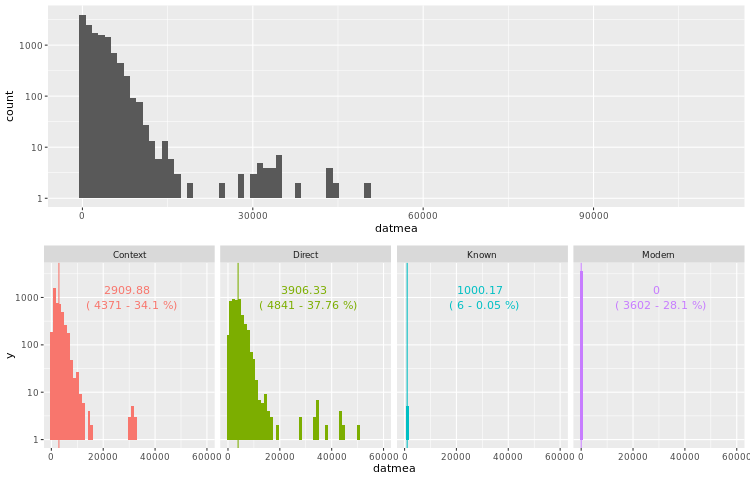

In [65]:
%%R -w 750

plot_grid(
    metadata %>% 
        filter(sntind) %>%
        select(master, datme2, datmea) %>%
        distinct() %>%
        ggplot() +
        geom_histogram(aes(x = datmea), bins = 100) +
        scale_y_log10(), 
    metadata %>% 
        filter(sntind) %>%
        select(master, datme2, datmea) %>%
        distinct() %>%
        ggplot() +
        geom_histogram(aes(x = datmea, fill = datme2), bins = 100, show.legend = F) +
        geom_vline(data = . %>% group_by(datme2) %>% summarize(mean = mean(datmea)), 
                   aes(xintercept = mean, color = datme2), show.legend = F) +
        geom_text(data = . %>% group_by(datme2) %>% summarize(mean = mean(datmea), n = n()) %>% mutate(perc = round(n*100/sum(n), 2)), 
                  aes(x = 30000, y = 1000, label = paste(round(mean, 2), "\n (", n, "-", perc, "%)"), color = datme2), show.legend = F) +
        coord_cartesian(xlim = c(0, 60000)) +
        scale_y_log10() +
        facet_wrap(.~datme2, nrow = 1), nrow = 2, align = "v")

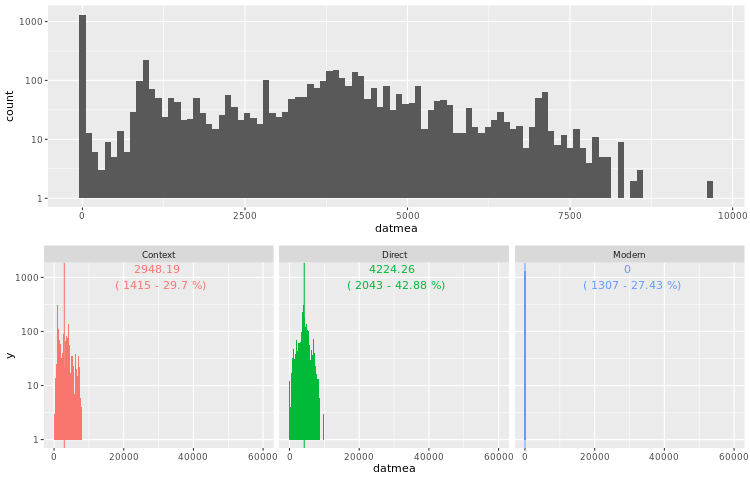

In [66]:
%%R -w 750

plot_grid(
    metadata %>% 
        filter(timind) %>%
        select(master, datme2, datmea) %>%
        distinct() %>%
        ggplot() +
        geom_histogram(aes(x = datmea), bins = 100) +
        scale_y_log10(), 
    metadata %>% 
        filter(timind) %>%
        select(master, datme2, datmea) %>%
        distinct() %>%
        ggplot() +
        geom_histogram(aes(x = datmea, fill = datme2), bins = 100, show.legend = F) +
        geom_vline(data = . %>% group_by(datme2) %>% summarize(mean = mean(datmea)), 
                   aes(xintercept = mean, color = datme2), show.legend = F) +
        geom_text(data = . %>% group_by(datme2) %>% summarize(mean = mean(datmea), n = n()) %>% mutate(perc = round(n*100/sum(n), 2)), 
                  aes(x = 30000, y = 1000, label = paste(round(mean, 2), "\n (", n, "-", perc, "%)"), color = datme2), show.legend = F) +
        coord_cartesian(xlim = c(0, 60000)) +
        scale_y_log10() +
        facet_wrap(.~datme2, nrow = 1), nrow = 2, align = "v")

In [67]:
np.sqrt((750-500)**2)/500

0.5

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



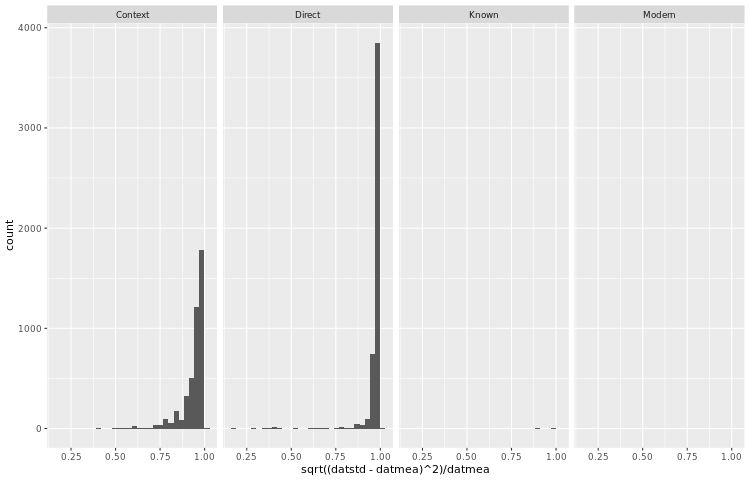

In [68]:
%%R -w 750


metadata %>% 
    filter(sntind) %>%
    filter(datstd < 3000, datmea < 60000) %>%
    ggplot() +
    geom_histogram(aes(x = sqrt((datstd-datmea)^2)/datmea)) +
    facet_wrap(.~datme2, nrow = 1)

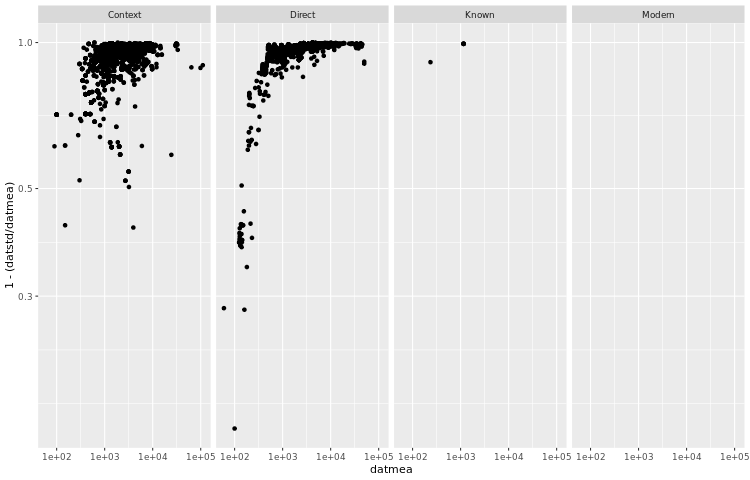

In [69]:
%%R -w 750


metadata %>% 
    filter(sntind) %>%
    #filter(datstd < 3000, datmea < 60000) %>%
    ggplot() +
    geom_point(aes(x = datmea, y = 1-(datstd/datmea))) +
    facet_wrap(.~datme2, nrow = 1) +
    scale_y_log10() +
    scale_x_log10() 

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



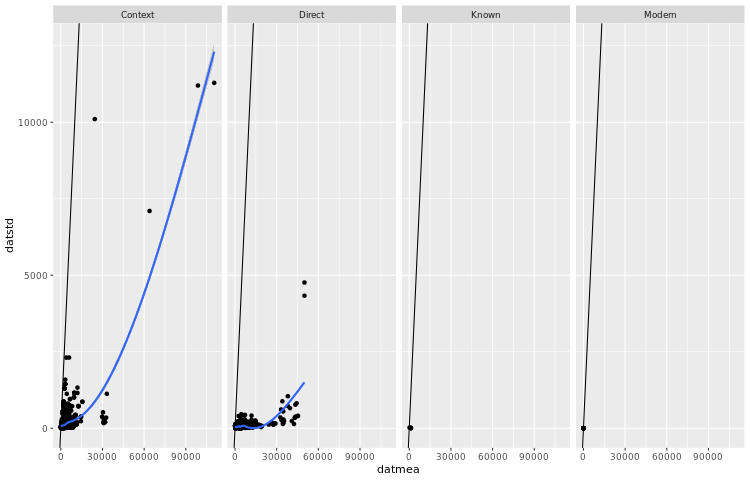

In [70]:
%%R -w 750


metadata %>% 
    filter(sntind) %>%
    #filter(datstd < 3000, datmea < 60000) %>%
    ggplot() +
    geom_abline(slope = 1) +
    geom_point(aes(x = datmea, y = datstd)) +
    geom_smooth(aes(x = datmea, y = datstd)) +
    facet_wrap(.~datme2, nrow = 1)

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



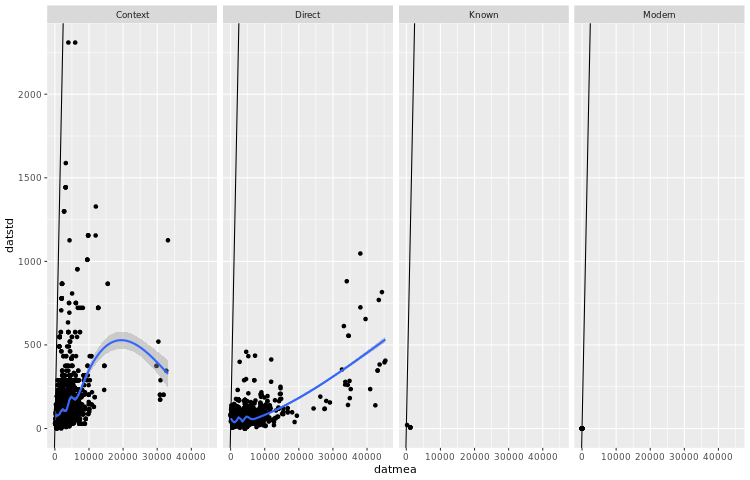

In [71]:
%%R -w 750


metadata %>% 
    filter(sntind) %>%
    filter(datstd < 3000, datmea < 60000) %>%
    ggplot() +
    geom_abline(slope = 1) +
    geom_point(aes(x = datmea, y = datstd)) +
    geom_smooth(aes(x = datmea, y = datstd)) +
    facet_wrap(.~datme2, nrow = 1)

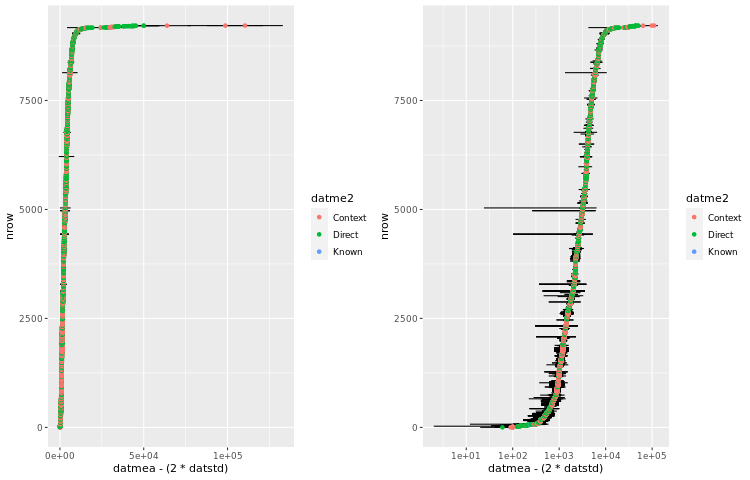

In [72]:
%%R -w 750

plot_grid(
    metadata %>% 
        filter(sntind) %>%
        filter(datme2 != "Modern") %>%
        arrange(datmea) %>%
        mutate(nrow = 1:n()) %>%
        ggplot() +
        geom_segment(aes(x = datmea-(2*datstd), xend = datmea+(2*datstd), y = nrow, yend = nrow)) +
        geom_point(aes(y = nrow, x = datmea, color = datme2)),

    metadata %>% 
        filter(sntind) %>%
        filter(datme2 != "Modern") %>%
        arrange(datmea) %>%
        mutate(nrow = 1:n()) %>%
        ggplot() +
        geom_segment(aes(x = datmea-(2*datstd), xend = datmea+(2*datstd), y = nrow, yend = nrow)) +
        geom_point(aes(y = nrow, x = datmea, color = datme2)) +
        scale_x_log10(),

    nrow = 1)

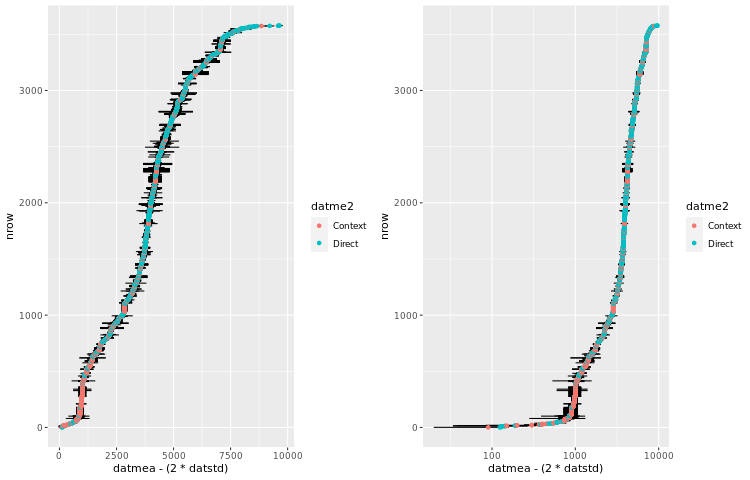

In [73]:
%%R -w 750

plot_grid(
    metadata %>% 
        filter(timind) %>%
        filter(datme2 != "Modern") %>%
        arrange(datmea) %>%
        mutate(nrow = 1:n()) %>%
        ggplot() +
        geom_segment(aes(x = datmea-(2*datstd), xend = datmea+(2*datstd), y = nrow, yend = nrow)) +
        geom_point(aes(y = nrow, x = datmea, color = datme2)),

    metadata %>% 
        filter(timind) %>%
        filter(datme2 != "Modern") %>%
        arrange(datmea) %>%
        mutate(nrow = 1:n()) %>%
        ggplot() +
        geom_segment(aes(x = datmea-(2*datstd), xend = datmea+(2*datstd), y = nrow, yend = nrow)) +
        geom_point(aes(y = nrow, x = datmea, color = datme2)) +
        scale_x_log10(),

    nrow = 1)

In [74]:
%%R

metadata %>% 
    filter(sntind) %>%
    filter(datme2 != "Modern") %>%
    pull(datmea) %>%
    quantile()

       0%       25%       50%       75%      100% 
    60.00   1392.00   2850.00   4429.25 110450.00 


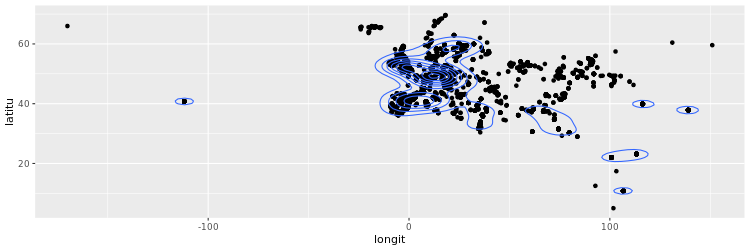

In [75]:
%%R -w 750 -h 250

metadata %>% 
        filter(timind) %>%
        mutate(latitu = as.numeric(as.character(latitu)),
               longit = as.numeric(as.character(longit))) %>%
        ggplot() +
        geom_point(aes(x = longit, y = latitu)) +
        geom_density2d(aes(x = longit, y = latitu))

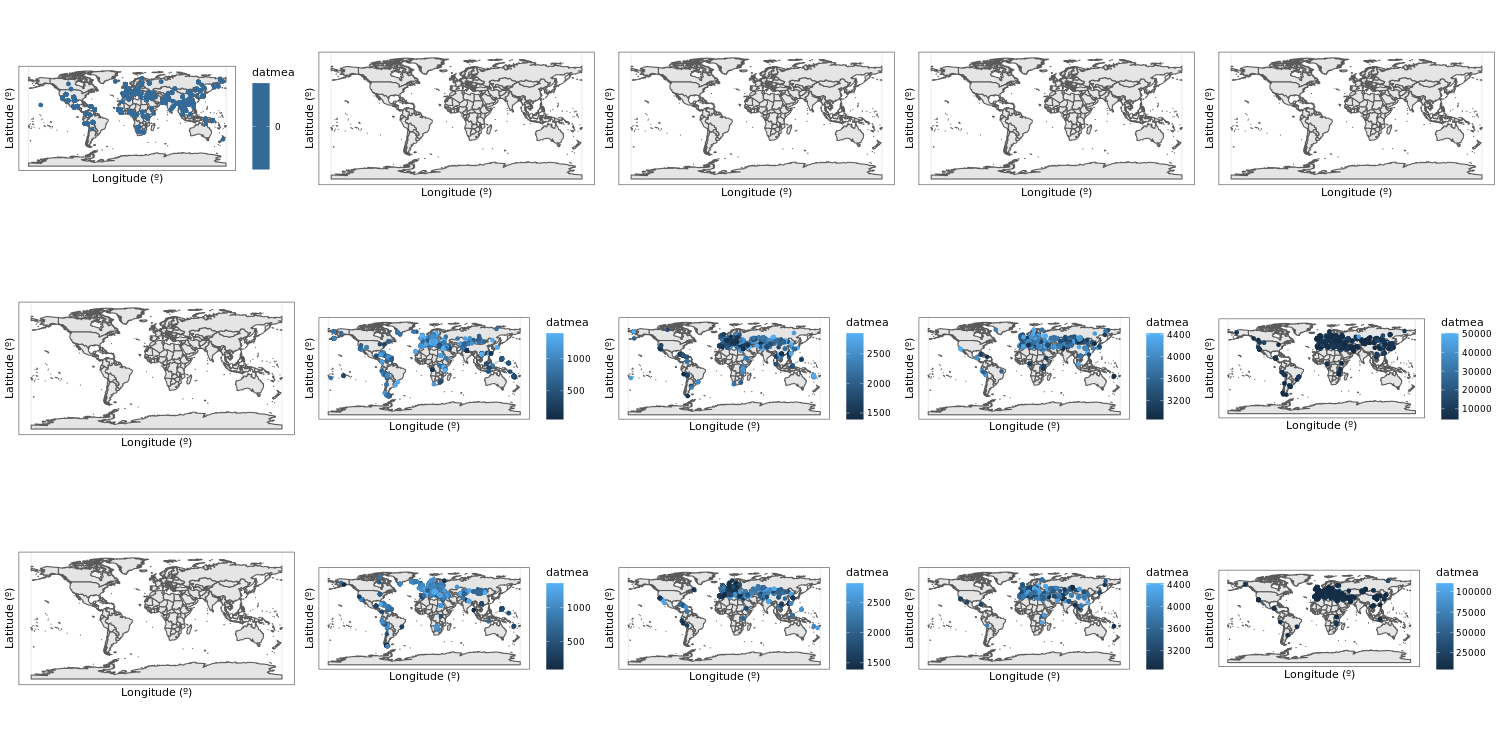

In [76]:
%%R -w 1500 -h 750

map_plot <- function(mintim, maxtim, datmef){
    metadata %>% 
        filter(sntind) %>%
        filter(datmea >= mintim, datmea < maxtim, datme2 == datmef) %>%
        mutate(latitu = as.numeric(as.character(latitu)),
               longit = as.numeric(as.character(longit))) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = longit, y = latitu, color = datmea)) +
        xlab("Longitude (º)") +
        ylab("Latitude (º)") +
        theme_bw()
}

plot_grid(map_plot(0, 1, "Modern"),  map_plot(60, 1392, "Modern"),  map_plot(1392, 2850, "Modern"),  map_plot(2850, 4430, "Modern"),  map_plot(4430, 120000, "Modern"),
          map_plot(0, 1, "Direct"),  map_plot(60, 1392, "Direct"),  map_plot(1392, 2850, "Direct"),  map_plot(2850, 4430, "Direct"),  map_plot(4430, 120000, "Direct"),
          map_plot(0, 1, "Context"), map_plot(60, 1392, "Context"), map_plot(1392, 2850, "Context"), map_plot(2850, 4430, "Context"), map_plot(4430, 120000, "Context"),
         nrow = 3)

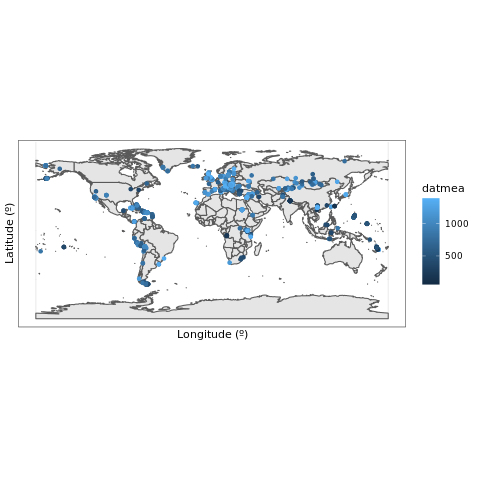

In [77]:
%%R

map_plot(60, 1392, "Direct")
